<a href="https://colab.research.google.com/github/PatrykGluszekDS/TensorFlow-Projects-Showcase/blob/main/Transfer-Learning/AgriAid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from collections import Counter

SEED = 42
tf.keras.utils.set_random_seed(SEED)

# Loading full dataset with 80 / 10 / 10 split

In [2]:
SEED = 42

splits = ['train[:80%]',   # 80 % → training
          'train[80%:90%]', # 10 % → validation
          'train[90%:]']    # 10 % → test

(ds_train, ds_val, ds_test), info = tfds.load(
    'plant_village',
    split=splits,
    shuffle_files=True,          # files are shuffled but deterministic
    as_supervised=True,
    with_info=True,
    read_config=tfds.ReadConfig(shuffle_seed=SEED)
)

NUM_CLASSES = info.features['label'].num_classes
print(info.splits['train'].num_examples, 'total images')

54303 total images


## Length of each split

In [3]:
def ds_len(ds):
    """Return dataset length without holding images in memory."""
    n = tf.data.experimental.cardinality(ds)
    if n == tf.data.INFINITE_CARDINALITY or n == tf.data.UNKNOWN_CARDINALITY:
        # Fallback: count on the fly (still low-RAM because it streams)
        n = sum(1 for _ in ds)
    else:
        n = n.numpy()
    return n

print("Train:", ds_len(ds_train))
print("Val  :", ds_len(ds_val))
print("Test :", ds_len(ds_test))

Train: 43442
Val  : 5431
Test : 5430


## Showing a 4 x 4 random image grid

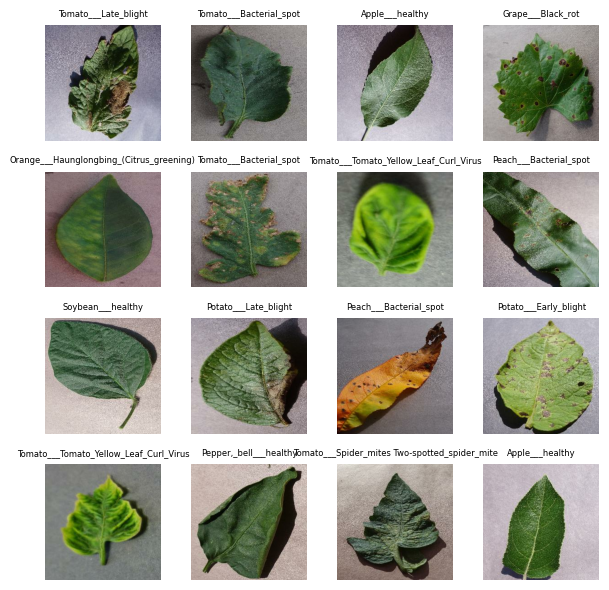

In [4]:
SAMPLES = 16
sample_ds = ds_train.shuffle(1000, seed=SEED).take(SAMPLES)

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for ax, (img, lbl) in zip(axes.flatten(), tfds.as_numpy(sample_ds)):
    ax.imshow(img)
    ax.set_title(info.features["label"].names[lbl], fontsize=6)
    ax.axis("off")
plt.tight_layout()
plt.savefig("sample_grid.png")
plt.show()

## Exploring the data for preprocessing

In [5]:
train_one_sample = ds_train.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 dataset: {label}
  Class name (str): {info.features['label'].names[label.numpy()]}
  """)


  Image shape: (256, 256, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 dataset: 20
  Class name (str): Potato___Early_blight
  


In [7]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

# Preprocessing data

In [8]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label

In [9]:
# Map preprocessing function to training (and parallelize)
ds_train = ds_train.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
ds_train = ds_train.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing functions to test data
ds_test = ds_test.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [10]:
ds_train, ds_test, ds_val

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Creating modeling callbacks

In [11]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [12]:
# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         verbose=0)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                    patience=4)

In [14]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                  factor=0.2,
                                                  patience=2,
                                                  verbose=1,
                                                 min_lr=1e-7)

# Setting up mixed precision training

In [15]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global policy to mixed precision

In [16]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

# Experiments

In [17]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [18]:
def compare_historys(original_history, new_history, initial_epochs=5):

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## 1. EfficientNetV2B0 feature extraction model without data augmentation

In [19]:
from tensorflow.keras import layers

In [20]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dense(NUM_CLASSES)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 38)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,967,990 (22.77 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [22]:
# Fit the feature extraction model with callbacks
history = model.fit(ds_train,
                    epochs=5,
                    steps_per_epoch=len(ds_train),
                    validation_data=ds_val,
                    validation_steps=len(ds_val),
                    callbacks=[create_tensorboard_callback("training_logs",
                                       "EfficientNetB0_feature_extraction"),
                                                         model_checkpoint, early_stopping, reduce_lr])

Saving TensorBoard log files to: training_logs/EfficientNetB0_feature_extraction/20250912-105437
Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 183s 100ms/step - accuracy: 0.7784 - loss: 0.9647 - val_accuracy: 0.9575 - val_loss: 0.1791 - learning_rate: 0.0010
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 63s 46ms/step - accuracy: 0.9579 - loss: 0.1716 - val_accuracy: 0.9727 - val_loss: 0.1107 - learning_rate: 0.0010
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 59s 42ms/step - accuracy: 0.9713 - loss: 0.1145 - val_accuracy: 0.9751 - val_loss: 0.0896 - learning_rate: 0.0010
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9763 - loss: 0.0890 - val_accuracy: 0.9799 - val_loss: 0.0733 - learning_rate: 0.0010
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.9802 - loss: 0.0738 - val_accuracy: 0.9821 - val_loss: 0.0666 - learning_rate: 0.0010


In [23]:
# Evaluate model on whole test dataset
results = model.evaluate(ds_test)
results

170/170 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - accuracy: 0.9838 - loss: 0.0580


[0.06090611219406128, 0.9834254384040833]

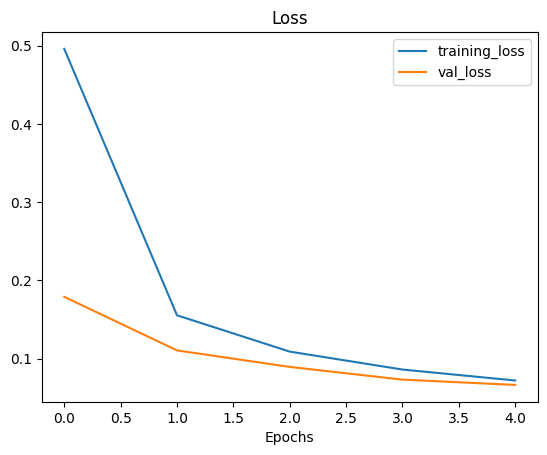

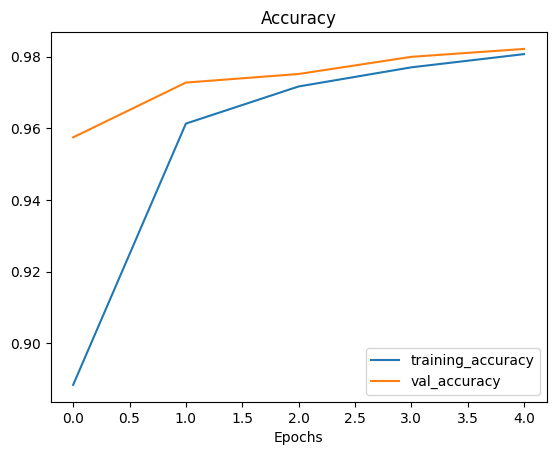

In [24]:
plot_loss_curves(history)

## 2. EfficientNetV2B0 feature extraction model with data augmentation

In [25]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [26]:
# Setup data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomZoom(0.2),
  # layers.Rescaling(1/255.) # rescale inputs of images to be between 0 & 1, required for models like ResNet
], name="data_augmentation")

In [27]:
input_shape = (224, 224, 3)
base_model_2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model_2.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer_2")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer_2")(x)
x = layers.Dense(NUM_CLASSES)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32_2")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [28]:
model_2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer_2  │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        48,678 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32_2 (Activation)  │ (None, 38)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,967,990 (22.77 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [29]:
history_2 = model_2.fit(ds_train,
                    epochs=5,
                    steps_per_epoch=len(ds_train),
                    validation_data=ds_val,
                    validation_steps=len(ds_val),
                    callbacks=[create_tensorboard_callback("training_logs",
                                       "EfficientNetB0_feature_extraction_aug"),
                                           early_stopping, reduce_lr])

Saving TensorBoard log files to: training_logs/EfficientNetB0_feature_extraction_aug/20250912-110807
Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 720s 512ms/step - accuracy: 0.7142 - loss: 1.2289 - val_accuracy: 0.9138 - val_loss: 0.3153 - learning_rate: 0.0010
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 279s 179ms/step - accuracy: 0.9242 - loss: 0.2957 - val_accuracy: 0.9341 - val_loss: 0.2276 - learning_rate: 0.0010
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 222s 150ms/step - accuracy: 0.9415 - loss: 0.2149 - val_accuracy: 0.9398 - val_loss: 0.1974 - learning_rate: 0.0010
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 238s 132ms/step - accuracy: 0.9464 - loss: 0.1857 - val_accuracy: 0.9495 - val_loss: 0.1691 - learning_rate: 0.0010
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 162s 118ms/step - accuracy: 0.9535 - loss: 0.1596 - val_accuracy: 0.9542 - val_loss: 0.1559 - learning_rate: 0.0010


In [30]:
results_2 = model_2.evaluate(ds_test)
results_2

170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9596 - loss: 0.1325


[0.14311978220939636, 0.9570902585983276]

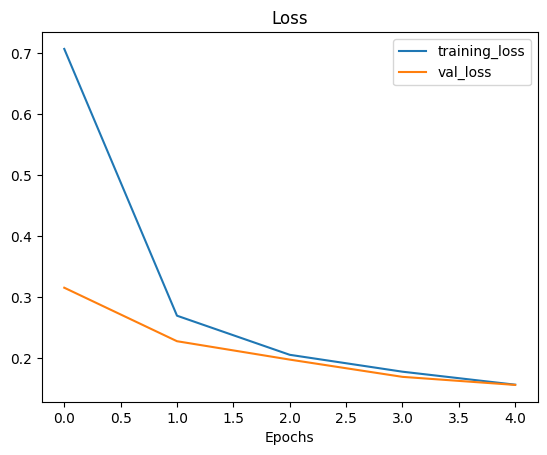

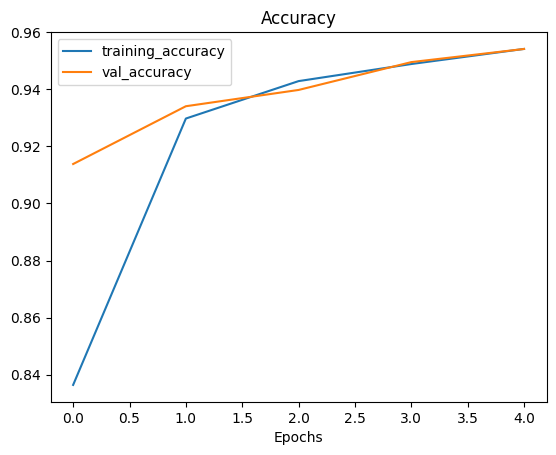

In [31]:
plot_loss_curves(history_2)

## 3. Fine-tuned EfficientNetV2B0 with data augmentation (2nd experiment)

In [32]:
# Unfreeze all of the layers in the base model
base_model_2.trainable = True

# Refreeze
for layer in base_model_2.layers[:-30]:
    layer.trainable = False

In [33]:
model_2.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [34]:
history_3 = model_2.fit(ds_train,
                    epochs=35,
                    steps_per_epoch=len(ds_train),
                    validation_data=ds_val,
                    validation_steps=len(ds_val),
                    initial_epoch=history_2.epoch[-1],
                    callbacks=[create_tensorboard_callback("training_logs",
                                       "EfficientNetB0_feature_extraction_aug_finetune"),
                                           early_stopping, reduce_lr])

Saving TensorBoard log files to: training_logs/EfficientNetB0_feature_extraction_aug_finetune/20250912-113613
Epoch 5/35
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 163s 110ms/step - accuracy: 0.9560 - loss: 0.1430 - val_accuracy: 0.9551 - val_loss: 0.1440 - learning_rate: 0.0010
Epoch 6/35
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 197s 106ms/step - accuracy: 0.9604 - loss: 0.1310 - val_accuracy: 0.9577 - val_loss: 0.1358 - learning_rate: 0.0010
Epoch 7/35
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 136s 99ms/step - accuracy: 0.9622 - loss: 0.1247 - val_accuracy: 0.9615 - val_loss: 0.1273 - learning_rate: 0.0010
Epoch 8/35
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 132s 96ms/step - accuracy: 0.9639 - loss: 0.1201 - val_accuracy: 0.9582 - val_loss: 0.1277 - learning_rate: 0.0010
Epoch 9/35
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9649 - loss: 0.1123
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 140s 95ms/step - accuracy: 0.9649 - loss: 0.1123 - val_accuracy

In [35]:
results_3 = model_2.evaluate(ds_test)
results_3

170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9713 - loss: 0.0883


[0.0939779132604599, 0.970349907875061]

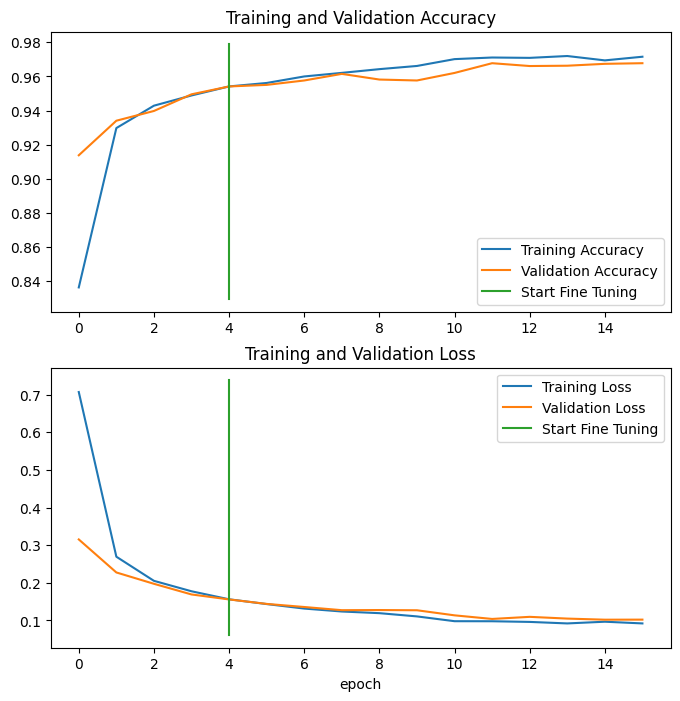

In [36]:
compare_historys(history_2, history_3)

## 4. ResNet50 feature extraction model without data augmentation

In [37]:
input_shape = (224, 224, 3)
base_model_4 = tf.keras.applications.resnet50.ResNet50(include_top=False)
base_model_4.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer_4")
x = layers.Rescaling(1./255)(inputs)
x = base_model_4(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer_4")(x)
x = layers.Dense(NUM_CLASSES)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32_4")(x)
model_4 = tf.keras.Model(inputs, outputs)

model_4.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [38]:
model_4.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer_4  │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │        77,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32_4 (Activation)  │ (None, 38)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,665,574 (90.28 MB)

 Trainable params: 77,862 (304.15 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [39]:
history_4 = model_4.fit(ds_train,
                    epochs=5,
                    steps_per_epoch=len(ds_train),
                    validation_data=ds_val,
                    validation_steps=len(ds_val),
                    callbacks=[create_tensorboard_callback("training_logs",
                                       "ResNet50_feature_extraction"),
                                                   early_stopping, reduce_lr])

Saving TensorBoard log files to: training_logs/ResNet50_feature_extraction/20250912-120251
Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 89s 55ms/step - accuracy: 0.1579 - loss: 3.2385 - val_accuracy: 0.2732 - val_loss: 2.8666 - learning_rate: 0.0010
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 118s 42ms/step - accuracy: 0.2736 - loss: 2.8120 - val_accuracy: 0.3016 - val_loss: 2.6574 - learning_rate: 0.0010
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 59s 43ms/step - accuracy: 0.3229 - loss: 2.6023 - val_accuracy: 0.3513 - val_loss: 2.4811 - learning_rate: 0.0010
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 64s 47ms/step - accuracy: 0.3563 - loss: 2.4550 - val_accuracy: 0.3764 - val_loss: 2.3722 - learning_rate: 0.0010
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 64s 46ms/step - accuracy: 0.3810 - loss: 2.3384 - val_accuracy: 0.4066 - val_loss: 2.2786 - learning_rate: 0.0010


In [40]:
results_4 = model_4.evaluate(ds_test)
results_4

170/170 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.4302 - loss: 2.2240


[2.2480862140655518, 0.4217311143875122]

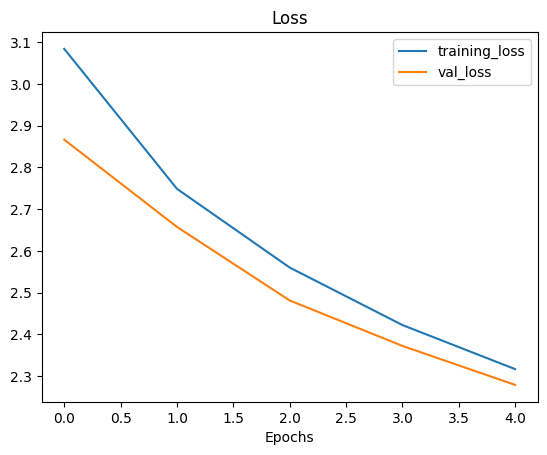

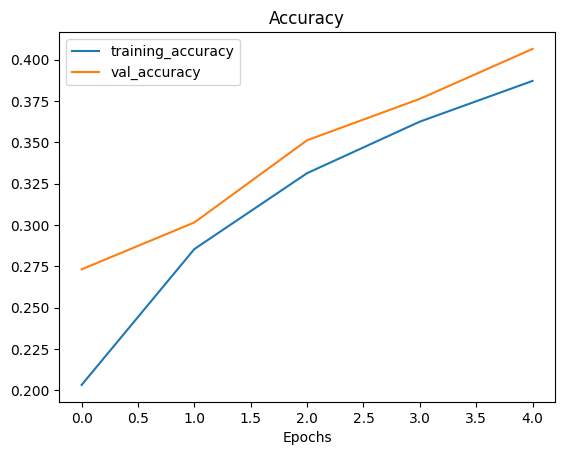

In [41]:
plot_loss_curves(history_4)

## 5. ResNet50 feature extraction model without data augmentation, with official preprocessing layer

In [42]:
from tensorflow.keras.applications.resnet import preprocess_input

In [43]:
input_shape = (224, 224, 3)
base_model_5 = tf.keras.applications.resnet50.ResNet50(include_top=False)
base_model_5.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer_5")
x = preprocess_input(inputs) # handles mean-sub & BGR
x = base_model_5(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer_5")(x)
x = layers.Dense(NUM_CLASSES)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32_5")(x)
model_5 = tf.keras.Model(inputs, outputs)

model_5.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [44]:
history_5 = model_5.fit(ds_train,
                    epochs=5,
                    steps_per_epoch=len(ds_train),
                    validation_data=ds_val,
                    validation_steps=len(ds_val),
                    callbacks=[create_tensorboard_callback("training_logs",
                                       "ResNet50_feature_extraction_offpreprocess"),
                                                   early_stopping, reduce_lr])

Saving TensorBoard log files to: training_logs/ResNet50_feature_extraction_offpreprocess/20250912-121025
Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.8538 - loss: 0.6165 - val_accuracy: 0.9672 - val_loss: 0.0998 - learning_rate: 0.0010
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 60s 43ms/step - accuracy: 0.9789 - loss: 0.0743 - val_accuracy: 0.9794 - val_loss: 0.0685 - learning_rate: 0.0010
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 58s 42ms/step - accuracy: 0.9873 - loss: 0.0447 - val_accuracy: 0.9801 - val_loss: 0.0598 - learning_rate: 0.0010
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 64s 46ms/step - accuracy: 0.9924 - loss: 0.0310 - val_accuracy: 0.9818 - val_loss: 0.0519 - learning_rate: 0.0010
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 60s 43ms/step - accuracy: 0.9949 - loss: 0.0215 - val_accuracy: 0.9820 - val_loss: 0.0527 - learning_rate: 0.0010


In [45]:
results_5 = model_5.evaluate(ds_test)
results_5

170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9854 - loss: 0.0447


[0.04484090209007263, 0.9856353402137756]

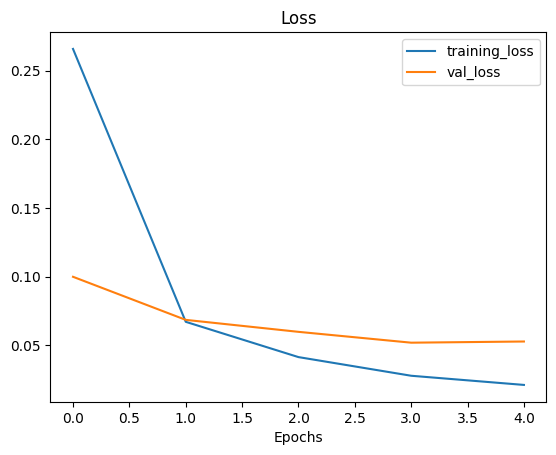

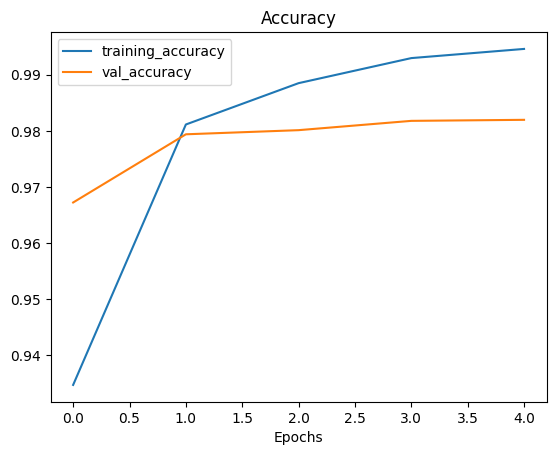

In [46]:
plot_loss_curves(history_5)

## 6. ResNet50 feature extraction model with data augmentation, with official preprocessing layer

In [47]:
data_augmentation_6 = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomZoom(0.2),
], name="data_augmentation_6")


input_shape = (224, 224, 3)
base_model_6 = tf.keras.applications.resnet50.ResNet50(include_top=False)
base_model_6.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer_6")
x = preprocess_input(inputs) # handles mean-sub & BGR
x = data_augmentation_6(x)
x = base_model_6(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer_6")(x)
x = layers.Dense(NUM_CLASSES)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32_6")(x)
model_6 = tf.keras.Model(inputs, outputs)

model_6.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [48]:
history_6 = model_6.fit(ds_train,
                    epochs=5,
                    steps_per_epoch=len(ds_train),
                    validation_data=ds_val,
                    validation_steps=len(ds_val),
                    callbacks=[create_tensorboard_callback("training_logs",
                                       "ResNet50_feature_extraction_offpreprocess_aug"),
                                                   early_stopping, reduce_lr])

Saving TensorBoard log files to: training_logs/ResNet50_feature_extraction_offpreprocess_aug/20250912-121641
Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 386s 277ms/step - accuracy: 0.7959 - loss: 0.8289 - val_accuracy: 0.9182 - val_loss: 0.2601 - learning_rate: 0.0010
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 273s 198ms/step - accuracy: 0.9515 - loss: 0.1676 - val_accuracy: 0.9280 - val_loss: 0.2181 - learning_rate: 0.0010
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 239s 175ms/step - accuracy: 0.9610 - loss: 0.1257 - val_accuracy: 0.9249 - val_loss: 0.2428 - learning_rate: 0.0010
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 229s 168ms/step - accuracy: 0.9653 - loss: 0.1078 - val_accuracy: 0.9392 - val_loss: 0.2029 - learning_rate: 0.0010
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 216s 158ms/step - accuracy: 0.9712 - loss: 0.0902 - val_accuracy: 0.9455 - val_loss: 0.1786 - learning_rate: 0.0010


In [49]:
results_6 = model_6.evaluate(ds_test)
results_6

170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.9490 - loss: 0.1596


[0.1686941534280777, 0.9486187696456909]

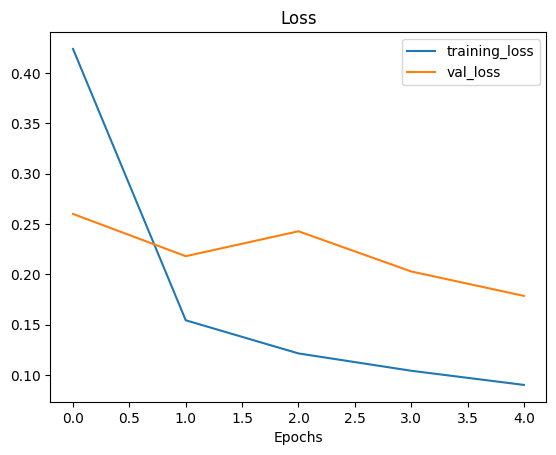

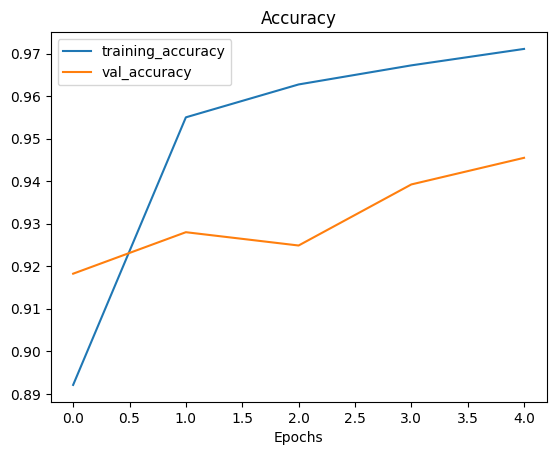

In [50]:
plot_loss_curves(history_6)

## 7. Fine-tuned ResNet50 model with data augmentation, with official preprocessing layer (6th experiment)

In [51]:
base_model_6.trainable = True

for layer in base_model_6.layers[:-30]:
    layer.trainable = False

In [52]:
model_6.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [53]:
history_7 = model_6.fit(ds_train,
                    epochs=35,
                    steps_per_epoch=len(ds_train),
                    validation_data=ds_val,
                    validation_steps=len(ds_val),
                    initial_epoch=history_6.epoch[-1],
                    callbacks=[create_tensorboard_callback("training_logs",
                                       "ResNet50_fine-tuned_offpreprocess_aug"),
                                                   early_stopping, reduce_lr])

Saving TensorBoard log files to: training_logs/ResNet50_fine-tuned_offpreprocess_aug/20250912-123959
Epoch 5/35
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 284s 197ms/step - accuracy: 0.9452 - loss: 0.2146 - val_accuracy: 0.9573 - val_loss: 0.1702 - learning_rate: 0.0010
Epoch 6/35
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 291s 176ms/step - accuracy: 0.9816 - loss: 0.0627 - val_accuracy: 0.9781 - val_loss: 0.0729 - learning_rate: 0.0010
Epoch 7/35
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 251s 167ms/step - accuracy: 0.9870 - loss: 0.0417 - val_accuracy: 0.9764 - val_loss: 0.0732 - learning_rate: 0.0010
Epoch 8/35
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9896 - loss: 0.0331
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 259s 165ms/step - accuracy: 0.9896 - loss: 0.0331 - val_accuracy: 0.9648 - val_loss: 0.1175 - learning_rate: 0.0010
Epoch 9/35
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 230s 169ms/step - accuracy: 0.9938 - loss: 0.0213 - val_accuracy: 0.9

In [55]:
results_7 = model_6.evaluate(ds_test)
results_7

170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.9888 - loss: 0.0349


[0.034257691353559494, 0.989871084690094]

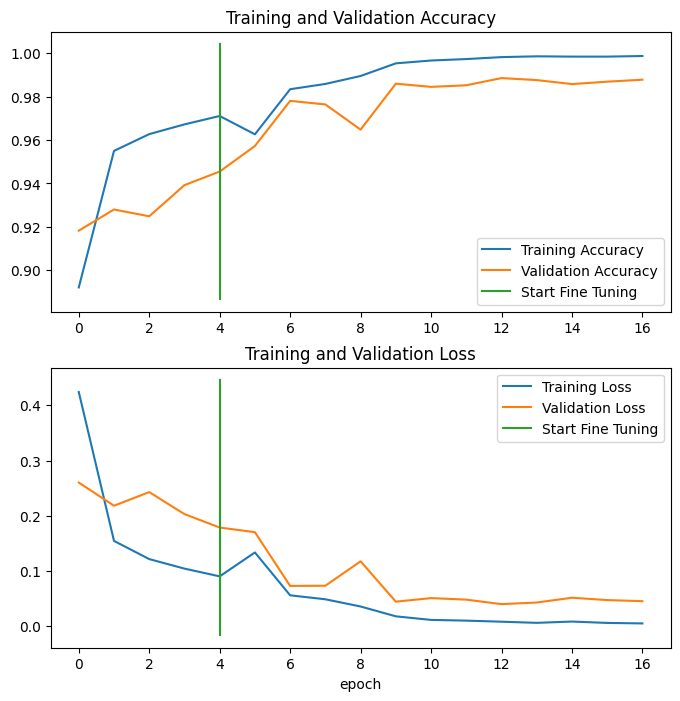

In [56]:
compare_historys(history_6, history_7)